In [5]:
%pylab inline --no-import-all
import pandas as pd
from scipy import optimize
import seaborn as sns
from scipy import stats
from scipy.stats import yeojohnson
import statsmodels.formula.api as smf
sns.set(context='talk', style='darkgrid')
dpi=96
online=True

Populating the interactive namespace from numpy and matplotlib


In [2]:
def linear(x, slope, y_intercept):
    return x * slope + y_intercept
def exponential(X, a, b):
    return a * np.exp(b * X)
rng = np.random.default_rng(seed=99)
X = rng.normal(10, 3, 100)
err = rng.normal(0, 0.5, 100)
def true_fit(X):
    return 1.85 * 10 ** (0.18 * X - 1.8)
Y = np.power(10, np.log10(true_fit(X)) + err)

# Misstep 3: Interpreting R-squared incorrectly
## Example A: Decline curve analysis

In decline curve analysis, you're working with a well that is usually (ideally?) kept at relatively constant operating conditions. The drawdown pressure stays about the same, the take-away capacity is about the same, and the reservoir is slowly depleting. In this situation, production is strongly auto-correlated. Therefore, you can't trust R$^2$. In this example, we show how the wrong decline curve equation (Exponential decline) can still have a very high R$^2$ when it badly misses tail-end production.

If you're feeling adventerous, you can try the stretched exponential fit (commented out) below.

In [3]:
def arps_eq(t: np.ndarray,b: float, D: float):
    q = (1 + err) / (1 + b * D * t)**(1/b)
    return q
def exponential_eq(t, q0, tau):
    q = q0 * np.exp(-t/tau)
    return q
def sepd_eq(t, q0, tau, beta):
    q = q0 * np.exp(-t ** beta/tau)
    return q

correlation coefficient for an exponential fit is 0.952
55.55385068843385 55.180825744702354
Over a 20 year period, the exponential fit would underpredict Arps by 0.67%


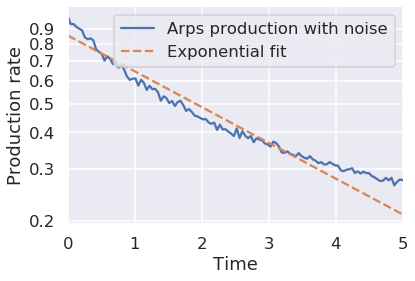

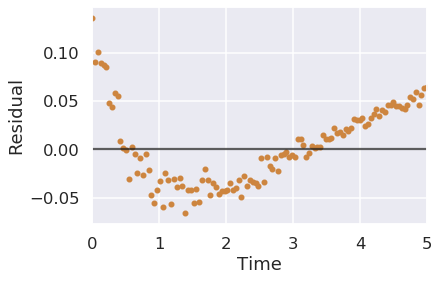

In [27]:
t = np.linspace(0, 5, 120)
b = 1.3
D = 0.7

err_sd = 0.01
np.random.seed(420)
err = np.random.normal(0, err_sd, len(t))
q = arps_eq(t, b, D) * (1 + err)

fig, ax = plt.subplots()
ax.semilogy(t,q, label='Arps production with noise')
# exponential fit
(q0, tau), _ = optimize.curve_fit(exponential_eq, t, q)
q_exp = exponential_eq(t, q0, tau)
ax.semilogy(t, q_exp, '--', label="Exponential fit")
print(f"correlation coefficient for an exponential fit is {np.corrcoef(q, q_exp)[0,1]**2:.3f}")

#stretched exponential fit
#(q0, tau, beta), _ = optimize.curve_fit(sepd_eq, t, q)
#q_sepd = sepd_eq(t, q0, tau, beta)
#plt.semilogy(t, q_sepd, '--', label='Stretched Exponential fit')
#print(f"correlation coefficient for SEPD is {np.corrcoef(q, q_sepd)[0,1]**2:.3f}")

sns.despine()
ax.set(xlabel="Time", xlim=(0,5), ylabel='Production rate')
#ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
ticks = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.yticks(ticks, ticks)
plt.legend(loc='best')
if not online:
    plt.savefig(figdir + 'Arps_production_fit.png', dpi=300, bbox_inches='tight')

    
fig, ax = plt.subplots()
ax.plot(t,np.zeros_like(t), color='k', alpha=.7)
ax.scatter(t, q-q_exp, marker='.',c='peru')
ax.set(xlabel='Time', ylabel='Residual', xlim=(min(t), max(t)))
t2 = np.linspace(0,20, 20*120)
q2 = arps_eq(t, b, D)
q_exp2 = exponential_eq(t, q0, tau)
print(sum(q2), sum(q_exp2))
print(f"Over a 20 year period, the exponential fit would underpredict Arps by {1-sum(q_exp2)/sum(q2):.2%}")

Here is a plot of autocorrelation

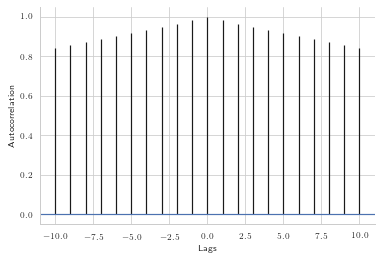

In [8]:
fig, ax = plt.subplots()
lags, c, _, _ = ax.acorr(q)
ax.set(xlabel="Lags", ylabel="Autocorrelation")
sns.despine()
fig.savefig(figdir + "Arps_autocorrelations.png", dpi=300, bbox_inches='tight')

A remedy for autocorrelation is applying Heteroskedasticity- and autocorrelation-consistent (HAC) estimators. Here we have an example using statsmodels

In [9]:
df = pd.DataFrame({'t':t, 'q':q})

# Use HAC to correct for heteroscedasticity and autocorrelation in regression
# Note: it does not work very well in this case
reg = (smf.ols('np.log(q) ~ 1 + t',data=df)
       .fit(cov_type='HAC',cov_kwds={'maxlags':5})
      )
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:              np.log(q)   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     298.4
Date:                Fri, 08 May 2020   Prob (F-statistic):           4.23e-34
Time:                        12:42:48   Log-Likelihood:                 134.91
No. Observations:                 120   AIC:                            -265.8
Df Residuals:                     118   BIC:                            -260.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2387      0.043     -5.562      0.0

# Case B: multimodal response

In geologic datasets, it is extremely common to have multiple modes for petrophysical measurements and log responses. A particularly common example is alternating between high-porosity, high-permeability, low-gamma ray sandstone and low-porosity, low-permeability, high-gamma ray shale layers.

In this example, we generate two clusters of data ($X1$ at 0, $X2$ at 6) and create a $y$ variable that follows a quadratic relationship with $x$. Because the clusters are far enough apart, a linear model appears to match quite well, with an $R^2$ in default settings of 0.9. But it's the wrong function! A look at the residuals immediately clears up the problem.

It is instructive to play with other nonlinear functions (line 8) and the center location of $X2$ (line 4).

The correlation is 0.909


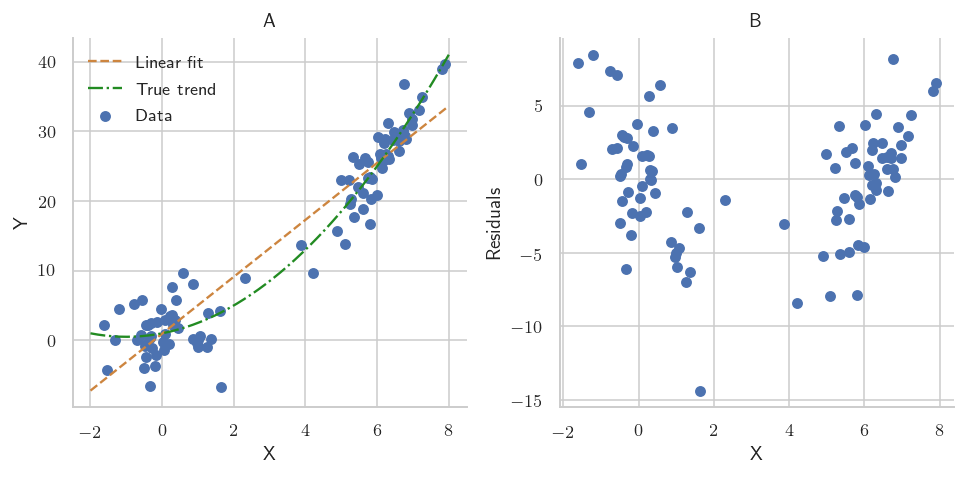

In [10]:
rng = np.random.default_rng(seed=420)

X1 = rng.normal(0, 1, 50)
X2 = rng.normal(6, 1, 50) # change the first argument to space the clusters further or closer
X = np.concatenate([X1, X2])
err = rng.normal(0, 3, 100)

Y = 1 + X + 0.5 * X **2 + err # change me!

def linear(x, slope, y_intercept):
    return x * slope + y_intercept

if talk:
    figsize= (10, 5)
else:
    figsize=(7, 3.5)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize, dpi=dpi)
plt.sca(ax1)
plt.scatter(X,Y, label="Data")

(slope, y_intercept), _ = optimize.curve_fit(linear, X, Y)
Y_pred = linear(X, slope, y_intercept)

resid = Y - Y_pred

X_pred = np.linspace(-2,8)
Y_pred2 = linear(X_pred, slope, y_intercept)
Y_true = 1 + X_pred + 0.5 * X_pred ** 2
ax1.plot(X_pred, Y_pred2, '--', label="Linear fit", color='peru')
ax1.plot(X_pred, Y_true, '-.', label='True trend', color='forestgreen')
ax1.set(xlabel='X', ylabel='Y', title='A')
ax1.legend(frameon=False)

ax2.scatter(X, resid)
ax2.set(xlabel='X', ylabel='Residuals', title="B")

fig.tight_layout()
sns.despine()
if not online:
    fig.savefig(figdir + "Multimodal_inputs.png", dpi=300, bbox_inches='tight')

R2 = np.corrcoef(Y, Y_pred)[0,1]**2
print(f"The correlation is {R2:.3f}")

# Case C: Skewed response variable
A common situation that is often overlooked comes from skewed response variables. In this case there are fat tails to the variable you are regressing on, and in extreme cases you are just fitting to the tails and not giving the bulk of the data the attention they deserve. Here are two cases.

## Exponential input
The response variable might follow a log-normal or power distribution. The classic sign for this is varying by several powers of 10 (say, from 0.1 to 100). Permeability is a perennial offender. Pore-sizes are also known to do this, as are fracture sizes.   
To solve this, test out logarithmic and Yeo-Johnson or Box-Cox transformations. These algorithms transform the data to follow a more normal distribution, alleviating some of the tail effects.  
In this example, we see the difference between using an exponential fit in linear coordinates (A) versus log coordinates (B). You can see that the linear coordinates fit introduced a bias (orange vs green dashed lines).

The R^2 of this heteroscedastic distribution is 0.718
The R^2 of the power-transformed distribution is 0.894
The lambda that best fits is -0.11
The R^2 of the log-transformed distribution is 0.902
The best fit form is Y = 1.3 * exp(0.91 * X)
The best fit after transform is Y = 0.98 * exp(0.99 * X)


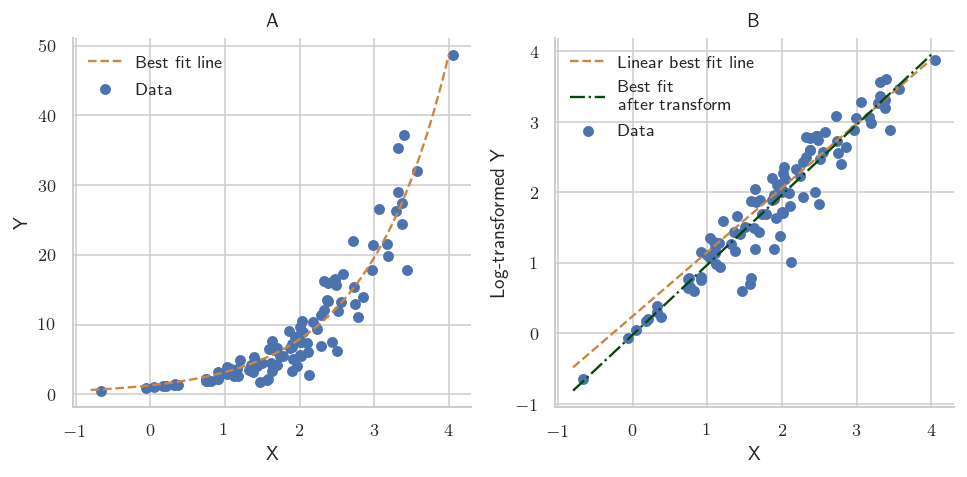

In [11]:
rng = np.random.default_rng(seed=116)

X = rng.normal(2, 1, 100)
err = rng.normal(0, 0.6* X**2, 100)

Y = np.exp(X) + err
print(f"The R^2 of this heteroscedastic distribution is {np.corrcoef(X, Y)[0,1]**2:.3f}")

Y_yeo_johnson, lambda1 = yeojohnson(Y)
print(f"The R^2 of the power-transformed distribution is {np.corrcoef(X, Y_yeo_johnson)[0,1]**2:.3f}")
Y_log = np.log(Y)
print(f"The lambda that best fits is {lambda1:.2f}")
print(f"The R^2 of the log-transformed distribution is {np.corrcoef(X, Y_log)[0,1]**2:.3f}")


def linear(x, slope, y_intercept):
    return x * slope + y_intercept
(a, b), _ = optimize.curve_fit(exponential, X, Y)
#(a_yj, b_yj), _ = optimize.curve_fit(linear, X, Y_yeo_johnson)

(a_transformed, b_transformed), _ = optimize.curve_fit(linear, X, Y_log)
print(f"The best fit form is Y = {a:.2} * exp({b:.2} * X)")
print(f"The best fit after transform is Y = {np.exp(b_transformed):.2} * exp({a_transformed:.2} * X)")

X_pred = np.linspace(-.8, 4)
Y_pred = exponential(X_pred, a, b)
Y_pred_log = linear(X_pred, a_transformed, b_transformed)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize, dpi=dpi)
ax1.scatter(X,Y, label="Data")
ax1.plot(X_pred, Y_pred, '--', color='peru', label="Best fit line")
ax1.legend(loc='best', frameon=False)
ax1.set(xlabel="X", ylabel="Y", title='A')

ax2.scatter(X, Y_log, label='Data')
ax2.plot(X_pred,np.log(Y_pred), '--', color='peru', label='Linear best fit line')
ax2.plot(X_pred, Y_pred_log, '-.', color=sns.xkcd_rgb['forest green'], label='Best fit\nafter transform')
ax2.set(xlabel="X", ylabel="Log-transformed Y", title="B")
ax2.legend(loc='upper left', frameon=False)

sns.despine()
plt.tight_layout()
if not online:
    fig.savefig(figdir + "exponential_input.png", dpi=300, bbox_inches='tight')

## Censored distribution

Another common situation is censored data. This happens when you reach the physical limits of the data-collection technique, for instance when a permeameter is working with a very low permeability sample or an FMI log was set to the wrong sensitivity and could not capture high or low resistivity measurements.  
In this example, you can see the $R^2$ and fit are negatively affected by the zero cutoff. It is extremely easy to check for censoring through 1) knowing how the data was collected and 2) plotting the distribution of the data. Alleviating this problem is a more difficult proposition. One approach is trimming outliers, but this must be done very carefully. Another is the [Tobit model](https://en.wikipedia.org/wiki/Tobit_model).

The R^2 for the non-censored case would be 0.820
The R^2 for the censored case is 0.783
The slope and y_intercept of the fits are slope=0.91 and y_intercept=0.17


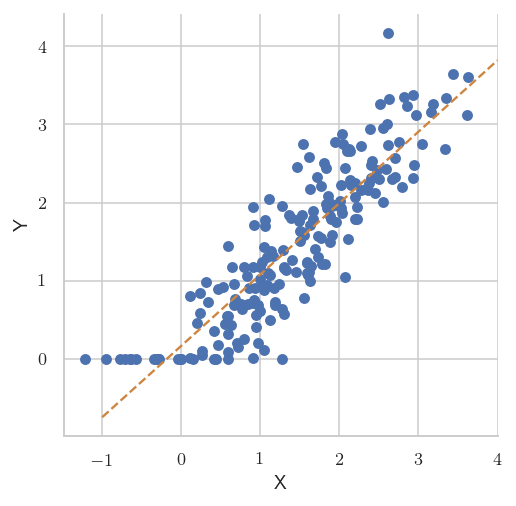

In [12]:
rng = np.random.default_rng(seed=96)

X = rng.normal(1.5, 1, 200)
err = rng.normal(0, 0.5, 200)

Y = X + err
print(f"The R^2 for the non-censored case would be {np.corrcoef(X, Y)[0,1]**2:.3f}")
Y[Y<0] = 0
print(f"The R^2 for the censored case is {np.corrcoef(X, Y)[0,1]**2:.3f}")
def linear(x, slope, y_intercept):
    return x * slope + y_intercept
(slope, y_intercept), _ = optimize.curve_fit(linear, X, Y)
Y_pred = linear(X, slope, y_intercept)
#resid = Y - Y_pred
X_pred = np.linspace(-1,4)
Y_pred2 = linear(X_pred, slope, y_intercept)

print(f"The slope and y_intercept of the fits are slope={slope:.2f} and y_intercept={y_intercept:.2f}")
fig, ax = plt.subplots(figsize=(4,4), dpi=dpi)
ax.scatter(X, Y, label='Data')
ax.plot(X_pred, Y_pred2,'--', color='peru', label='Fit')
ax.grid(True)
ax.set(xlabel="X", ylabel="Y", xlim=(None, 4))
sns.despine()
if not online:
    plt.savefig(figdir + "Censored.png", dpi=300, bbox_inches='tight')